<center><img src="images/header.png"></center>

<h1><center>Алгоритмы интеллектуальной обработки больших объемов данных</center></h1>
<hr>
<h2><center>SVM, Kernel Trick (практика)</center></h2>

**Срок сдачи:** 24 апреля 2017, 06:00 <br> 
**Штраф за опоздание:** -2 балла после 06:00 24 апреля, -4 балла после 06:00 1 мая, -6 баллов после 06:00 8 мая

При отправлении ДЗ указывайте фамилию в названии файла<br>

Не забудте создать задание в Slack через /todo.

Используйте данный Ipython Notebook при оформлении домашнего задания.

In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)

# Семинарская часть

Функция `select_model` принимает на вход обучающую выборку и возвращает модель (машину опорных векторов) с наилучшими параметрами для данной выборки. Эту функцию нужно реализовать.

Подбираемые параметры подели включают в себя:
- различные функции ядра (линейное, RBF, полиномиальные разных степеней)
- различные значения константы $C$ ($0, 0.1, 1, 10, 100, 1000, 10000$)

Подбирать параметры необходимо с помощью 10-fold кросс-валидации. Сейчас в качестве заглушки функция всегда возвращает линейный SVC.

In [14]:
def select_model(x, y):
    """
    Implement some model selection strategy here:
    seek through different kernels and parameters.

    Use a validation scheme to select the best model
    
    Quality metric: accuracy

    Returns:
        SVM classifier implemented by sklearn SVC class.
    """
    best_accuracy = 0
    best_model = None
    
    kernel = ['linear', 'rbf', 'linear']
    C = np.logspace(-1, 3, 8)
    acc = []
    
    for ker in kernel:
        for c in C:
            model = SVC(C=c, kernel=ker)
            accuracy = np.mean(cross_val_score(model, x, y))
            acc.append((ker, c, accuracy))
            
    acc = sorted(acc, key=lambda x : x[2])
    
    best_model = SVC(C = acc[0][1], kernel = acc[0][0])
    best_accuracy = acc[0][2]
    
    best_model.fit(x, y)
    print("Best model %s, with accuracy %f" % (best_model, best_accuracy))
    return best_model

SyntaxError: invalid syntax (<ipython-input-14-26a9d56a5c42>, line 19)

Далее две вспомогательные функции, которые отображают данные и разделяющую поверхность

In [ ]:
def plot_data_set(x, y, description=''):
    print("Plotting data set points")
    plt.figure(figsize=(8, 8))

    colors = np.array(['r', 'b'])[y]
    plt.title(description, fontsize='small')
    plt.scatter(x[:, 0], x[:, 1], marker='o', c=colors, s=50)
    
def plot_decision_region(x1_min, x2_min, x1_max, x2_max, clf, n_points=1000):
    print("Plotting decision region")
    x1, x2 = np.meshgrid(np.linspace(x1_min, x1_max, n_points), np.linspace(x2_min, x2_max, n_points))
    z = clf.decision_function(np.c_[x1.ravel(), x2.ravel()]).reshape(x1.shape)

    plt.contour(x1, x2, z, levels=[0.0], linestyles='solid', linewidths=2.0)
    plt.contour(x1, x2, z, levels=[-1.0, 1.0], linestyles='dashed', linewidths=1.0)

In [ ]:
def generate_linear(size=100, k=1.1, b=0.0, nl=0.1):
    print("Generating 'Linearly-separated' data set")

    x = np.random.random((size, 2))
    y = np.zeros(size, dtype=int)
    noise = np.random.randn(size) * nl
    y[x[:, 1] - (k * x[:, 0] + b) > noise] = 1

    return x, y

x, y = generate_linear()
clf = select_model(x, y)
plot_data_set(x, y)
plot_decision_region(x[:, 0].min(), x[:, 1].min(), x[:, 0].max(), x[:, 1].max(), clf)

In [ ]:
def generate_concentric(size=100, r1=1.0, r2=2.0, sigma=0.3):
    print "Generating 'Concentric circles' data set"
    x = np.zeros((size, 2))
    x[:size/2, 0] = sigma * np.random.randn(size/2) + r1
    x[size/2:, 0] = sigma * np.random.randn(size/2) + r2
    x[:, 1] = (np.random.random(size) - 0.5) * 2 * np.pi
    y = np.hstack([np.zeros(size/2, dtype=int), np.ones(size/2, dtype=int)])

    z = np.zeros((size, 2))
    z[:, 0] = x[:, 0] * np.cos(x[:, 1])
    z[:, 1] = x[:, 0] * np.sin(x[:, 1])

    return z, y

x, y = generate_concentric()
clf = select_model(x, y)
plot_data_set(x, y)
plot_decision_region(x[:, 0].min(), x[:, 1].min(), x[:, 0].max(), x[:, 1].max(), clf)

In [ ]:
def generate_sin(size=200):
    print "Generating 'Sinus-separated' data set"

    x = np.random.random((size, 2))
    x[:, 0] = x[:, 0] * 4 * np.pi
    x[:, 1] = (x[:, 1] - 0.5) * 2
    y = np.zeros(size, dtype=int)
    y[x[:, 1] > np.sin(x[:, 0])] = 1

    return x, y

x, y = generate_sin()
clf = select_model(x, y)
plot_data_set(x, y)
plot_decision_region(x[:, 0].min(), x[:, 1].min(), x[:, 0].max(), x[:, 1].max(), clf)

# Регрессия с SVM (3 балла)

Загрузите набор данных из *titanium.csv*<br/>
Мы будем решать задачу восстановления столбца 'y' по столбцу 'x'.

## Визуализация данных (1 балл)

Выполните стандартную предобработку данных (z-score) и выведите их на графике.

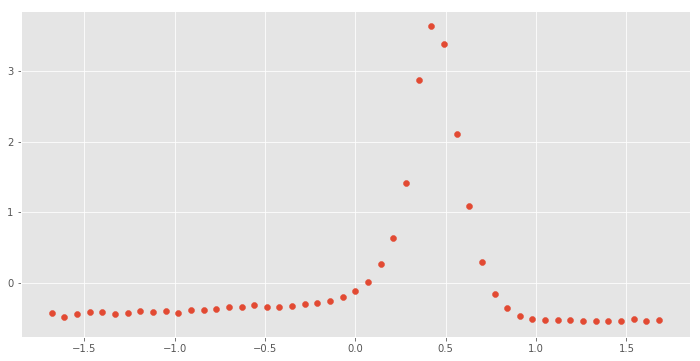

In [23]:
df = pd.read_csv('titanium.csv')
df.x = (df.x - df.x.mean()) / df.x.std()
df.y = (df.y - df.y.mean()) / df.y.std()
x = np.array(df.x.values)
y = np.array(df.y.values)
plt.scatter(x, y)

In [24]:
x = x.reshape((-1,1))

## Обучение моделей (2 балла)

Рассмотрите 3 ядра: 
* Линейное
* Полиномиальное (degree = 3, gamma = 6, coef0 = 1)
* RBF (gamma = 6, coef0 = 1)

Во всех случаях установить ширину трубки `epsilon=0.01`

Для каждого из ядер:
1. Пусть `C = np.logspace(-2, 2, 10)`. Постройте графики зависимости ошибки от параметра $C$ (ось графика со значениями параметра $C$ должна быть в логарифмической шкале). Ошибка измеряется как средняя абсолютная ошибка. 
2. Для наулучшего параметра $С$ каждого из ядер постройте график с данными и предстазанием по svm

В каких случаях возникает эффекты недообучения, переобучения?

In [25]:
from sklearn.metrics import mean_absolute_error

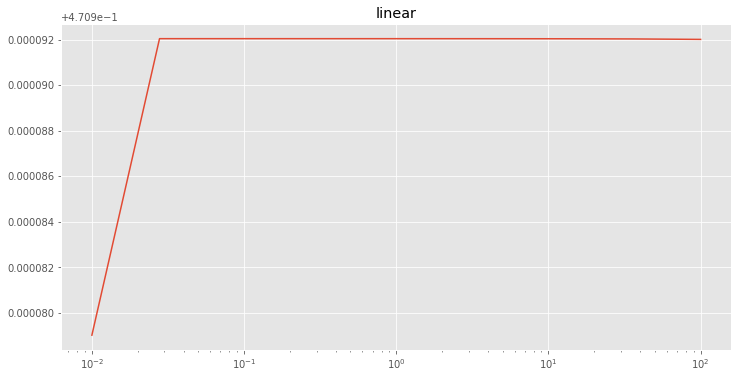

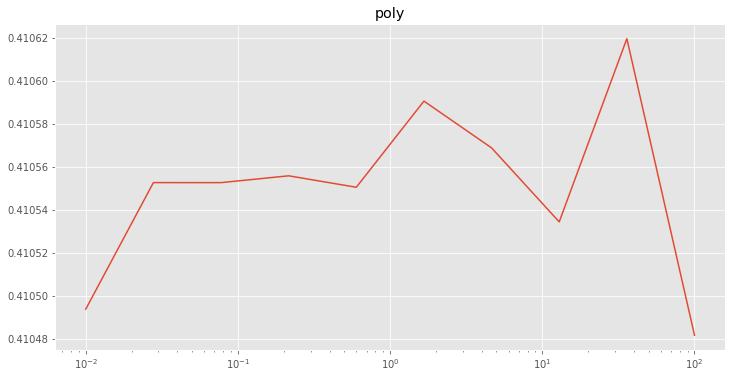

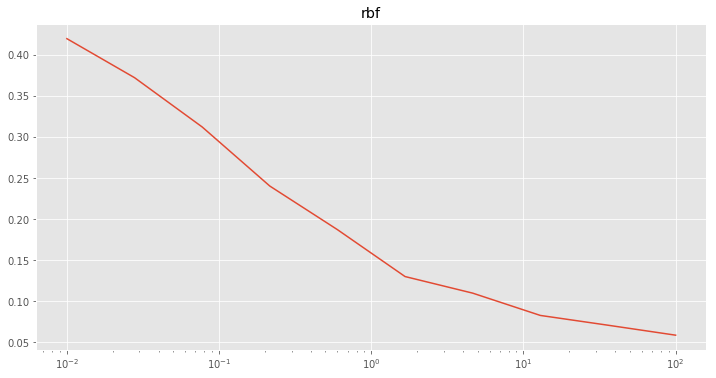

[  1.00000000e-02   2.78255940e-02   7.74263683e-02   2.15443469e-01
   5.99484250e-01   1.66810054e+00   4.64158883e+00   1.29154967e+01
   3.59381366e+01   1.00000000e+02]


In [26]:
C = np.logspace(-2, 2, 10)
err_linear = []
for c in C:
    model = SVR(C=c, kernel='linear', epsilon=0.01, coef0=1)
    model.fit(x, y)
    y_pr = model.predict(x)
    err_linear.append(mean_absolute_error(y_pred=y_pr, y_true=y))
err_linear = np.array(err_linear)

err_poly = []
for c in C:
    model = SVR(C=c, kernel='poly', epsilon=0.01, degree=3, gamma=6, coef0=1)
    model.fit(x, y)
    y_pr = model.predict(x)
    err_poly.append(mean_absolute_error(y_pred=y_pr, y_true=y))
err_poly = np.array(err_poly)

err_rbf = []
for c in C:
    model = SVR(C=c, kernel='rbf', epsilon=0.01, coef0=1, gamma=6)
    model.fit(x, y)
    y_pr = model.predict(x)
    err_rbf.append(mean_absolute_error(y_pred=y_pr, y_true=y))
err_rbf = np.array(err_rbf)

plt.xscale('log')
plt.title('linear')
plt.plot(C, err_linear)
plt.show()

plt.xscale('log')
plt.title('poly')
plt.plot(C, err_poly)
plt.show()

plt.xscale('log')
plt.title('rbf')
plt.plot(C, err_rbf)
plt.show()
print(C)

Используя метод локтя, где убывает, и выбирая минимум, где скорость убывания небольшая, выбираем нужные C  
для линейной : 0.01  
для полиномиальной : 10  
для rbf : 4.6

/home/delta37/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


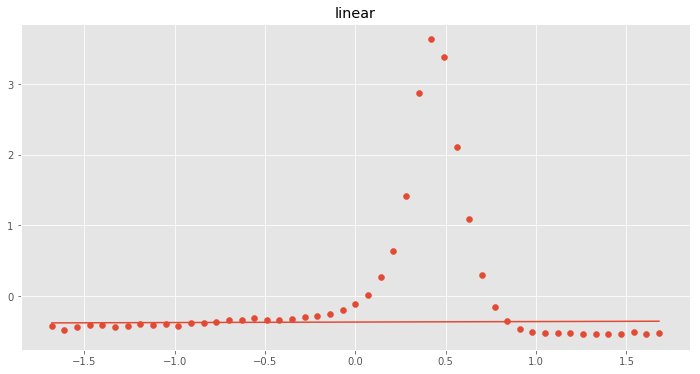

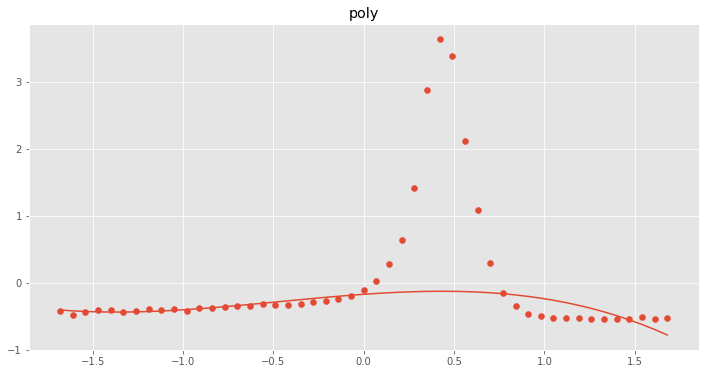

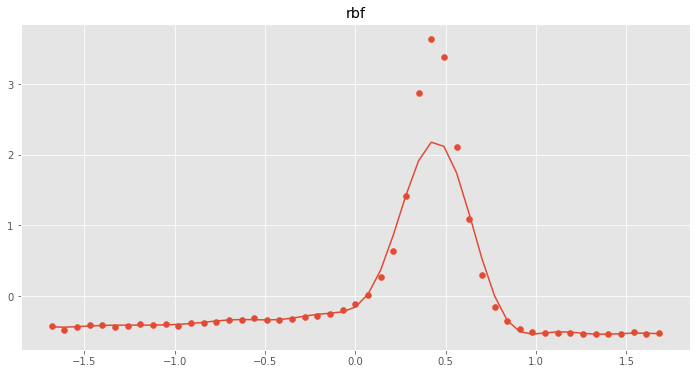

In [27]:
lmodel = SVR(C=0.01, kernel='linear', epsilon=0.01, coef0=1)
lmodel.fit(x, y)
y_l = lmodel.predict(x)

pmodel = SVR(C=100, kernel='poly', epsilon=0.01, coef0=1, gamma=6, degree=3)
pmodel.fit(x, y)
y_p = pmodel.predict(x)

rmodel = SVR(C=4.6, kernel='rbf', epsilon=0.01, coef0=1, gamma=6)
rmodel.fit(x, y)
y_r = rmodel.predict(x)

plt.title('linear')
plt.legend()
plt.scatter(x, y)
plt.plot(x, y_l)
plt.show()

plt.title('poly')
plt.legend()
plt.scatter(x, y)
plt.plot(x, y_p)
plt.show()

plt.title('rbf')
plt.legend()
plt.scatter(x, y)
plt.plot(x, y_r)
plt.show()


# Определение языка слова (7 баллов)

В данном задании вам необходимо определить, на каком языке написано слово.

Вам будет дано два текста - первые предложения произведения "Война и Мир" на английком и испанском, разбитые на слова. У слов нет общепринятого числового представления, поэтому мы предлагаем вам реализовать собственноге ядро для SVM, основанное на редакторском расстоянии или [расстоянии Левинштейна](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%9B%D0%B5%D0%B2%D0%B5%D0%BD%D1%88%D1%82%D0%B5%D0%B9%D0%BD%D0%B0). 

Имплементировать расстояние Леванштейна не нужно - можно взять любую доступную реализацию, например [здесь](https://github.com/toastdriven/pylev) или [здесь](https://github.com/ztane/python-Levenshtein).

## Загрузка (1 балл)

Загрузите данные из файлов *war_and_peace_es.txt* и *war_and_peace_en.txt*.<br/> 
В результате вы должны получить pandas.DataFrame со столбцами *index* | *word* | *label*, где *index* - это индекс pandas, *word* - это слово и *label* - это метка класса (0 или 1)

In [28]:
import pylev.pylev as pl
pl.levenshtein('sit', 'sid')

1

In [29]:
df0 = pd.read_csv('war_and_peace_en.txt', names=['word'])
df1 = pd.read_csv('war_and_peace_es.txt', names=['word'])
df0['label'] = 0
df1['label'] = 1
df = df0.append(df1)
df.index.name = 'index'

In [30]:
# like this

df.head()

,word,label
index,,
0,war,0
1,and,0
2,peace,0
3,leo,0
4,tolstoy,0


## Подготовка данных (2 балла)

Особенностью пользовательского ядра в sklean.SVC является то, что на вход оно должно принимать именно вектора чисел.<br/>
В нашем случае это будут индексы соответствующих слов из корпуса. То есть вместо вектора ['treat', 'celebrit', 'prince', ...] на вход в ядро подается вектор из индексов [9209, 11145, 7735, ...] с помощью которых вы будете находить сами слова.

Прежде чем мы начнем строить ядро, надо подготовить данные. Для этого:
1. Задайте переменную RND_SEED, которая будет использоваться в любых генераторах случайных чисел в вашем коде (обычно параметр "random_seed")
2. Случайным образом перемешайте и заново проиндексируйте таблицу, полученную выше (используйте методы df.sample() и df.reset_index())
3. Ядро может вычисляться достаточно долго, поэтому можете урезать таблицу, но оставить в ней не менее 1000 слов.
4. Разбейте данные на обучающую и контрольную выборку в пропорции 60/40

В результате вы должны получить вектор-столбец X_train, X_test с **индексами** слов и векторы y_train, y_test с метками классов.

In [31]:
from sklearn.cross_validation import train_test_split

In [32]:
RND_SEED = 2000
sampledf = df.sample(df.shape[0], random_state=RND_SEED)
sampledf = sampledf.reset_index().drop('index', axis=1)[0:1100]
sampledf.head()

,word,label
0,denghien,1
1,signora,1
2,ctait,1
3,dutched,0
4,their,0


In [33]:
X_train, X_test, y_train, y_test = train_test_split(sampledf.index.values, sampledf.label.values, 
                                                    random_state=RND_SEED, test_size=0.4)

In [55]:
X_train = X_train.reshape((-1,1))
X_test = X_test.reshape((-1,1))
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(660, 1) (660,)
(440, 1) (440,)


## Расчет ядра (3 балла)

Некоторые указания по составлению пользовательского ядра можно найти [здесь](http://stackoverflow.com/questions/26962159/how-to-use-a-custom-svm-kernel).

Если в двух словах:<br/>
Функция, реазлизующая расчет ядра должна принимать две матрицы $U$ и $V$ с признаковым описанием объектов (во време обучения они обе относятся к обучающей выборке, а во время применения - одна матрица относится к обучающей выборке, а другая к контрольной).

В результате, функция должна возвращать матрицу ядра $G_{ij} = K(U_i, V_j)$.

Таким образом, в этом задании вам надо:
1. Написать функцию *string_kernel(U, V)*, расчитывающее матрицу ядра $G_{ij}$
2. Визуализировать матрицу только для обучающей выборки (функция plt.imshow()).

**ВАЖНО**<br/>
На лекции мы рассмотрели, что ядро должно обладать определенными свойствами, поэтому не получится рассчитать $G_{ij}$ как расстояние Левинштейна между словами $\text{word}_i$ и $\text{word}_j$.<br/>
Вместо этого используйте какое-нибудь готовое ядро, зависящее от расстояние между объектами.

In [62]:
from tqdm import tqdm
def f(r, sig=0.1):
    '''
    gauss kernel
    '''
    return np.exp(-sig * r)

def string_kernel(U, V):
    #Your Code Here
    global sampledf
    n = len(U)
    m = len(V)
    G = np.zeros((n, m))
    for i in tqdm(range(n)):
        for j in range(m):
            G[i, j] = f(pl.levenshtein(sampledf.loc[U[i, 0]].word, sampledf.loc[V[j,0]].word))
    return G
G = string_kernel(X_train, X_train)


  1%|          | 7/660 [00:02<04:05,  2.66it/s]

100%|██████████| 660/660 [04:07<00:00,  2.72it/s]


In [63]:
G

array([[ 1.        ,  0.54881164,  0.4965853 , ...,  0.54881164,
         0.60653066,  0.54881164],
       [ 0.54881164,  1.        ,  0.4965853 , ...,  0.54881164,
         0.60653066,  0.54881164],
       [ 0.4965853 ,  0.4965853 ,  1.        , ...,  0.4965853 ,
         0.60653066,  0.54881164],
       ..., 
       [ 0.54881164,  0.54881164,  0.4965853 , ...,  1.        ,
         0.54881164,  0.54881164],
       [ 0.60653066,  0.60653066,  0.60653066, ...,  0.54881164,
         1.        ,  0.4965853 ],
       [ 0.54881164,  0.54881164,  0.54881164, ...,  0.54881164,
         0.4965853 ,  1.        ]])

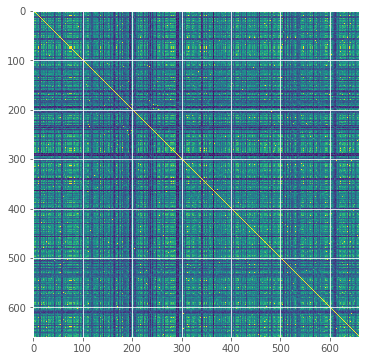

In [64]:
plt.imshow(G)

## Оценка качества (1 балл)

Обучите метод опорных векторов с различными значениями параметра штрафа $C$.<br/>
Для каждого значения выведите accuracy на обучащюей и контрольной выборке.

Постарайтесь достичь качества в 70% на тестовой выборке

In [48]:
from sklearn.metrics import accuracy_score

In [65]:
acc = []
C = np.logspace(-2, 2, 10)
for c in tqdm(C):
    model = SVC(C=c, kernel=string_kernel)
    model.fit(X_train, y_train)
    y_pr = model.predict(X_test)
    acc.append(accuracy_score(y_pred=y_pr, y_true=y_test))
    print(acc)

100%|██████████| 660/660 [04:23<00:00,  2.57it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

[0.53409090909090906]



100%|██████████| 660/660 [04:25<00:00,  2.23it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

[0.53409090909090906, 0.53409090909090906]



100%|██████████| 660/660 [04:48<00:00,  2.51it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

[0.53409090909090906, 0.53409090909090906, 0.57499999999999996]



100%|██████████| 660/660 [04:17<00:00,  2.63it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

[0.53409090909090906, 0.53409090909090906, 0.57499999999999996, 0.73863636363636365]



100%|██████████| 660/660 [04:13<00:00,  2.65it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

[0.53409090909090906, 0.53409090909090906, 0.57499999999999996, 0.73863636363636365, 0.80681818181818177]



100%|██████████| 660/660 [04:12<00:00,  2.66it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

[0.53409090909090906, 0.53409090909090906, 0.57499999999999996, 0.73863636363636365, 0.80681818181818177, 0.80909090909090908]



100%|██████████| 660/660 [04:12<00:00,  2.65it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

[0.53409090909090906, 0.53409090909090906, 0.57499999999999996, 0.73863636363636365, 0.80681818181818177, 0.80909090909090908, 0.76363636363636367]



100%|██████████| 660/660 [04:26<00:00,  2.39it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

[0.53409090909090906, 0.53409090909090906, 0.57499999999999996, 0.73863636363636365, 0.80681818181818177, 0.80909090909090908, 0.76363636363636367, 0.75]



100%|██████████| 660/660 [04:15<00:00,  2.68it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

[0.53409090909090906, 0.53409090909090906, 0.57499999999999996, 0.73863636363636365, 0.80681818181818177, 0.80909090909090908, 0.76363636363636367, 0.75, 0.74772727272727268]



100%|██████████| 660/660 [04:12<00:00,  2.10it/s]

100%|██████████| 10/10 [1:13:04<00:00, 433.61s/it]

[0.53409090909090906, 0.53409090909090906, 0.57499999999999996, 0.73863636363636365, 0.80681818181818177, 0.80909090909090908, 0.76363636363636367, 0.75, 0.74772727272727268, 0.75909090909090904]


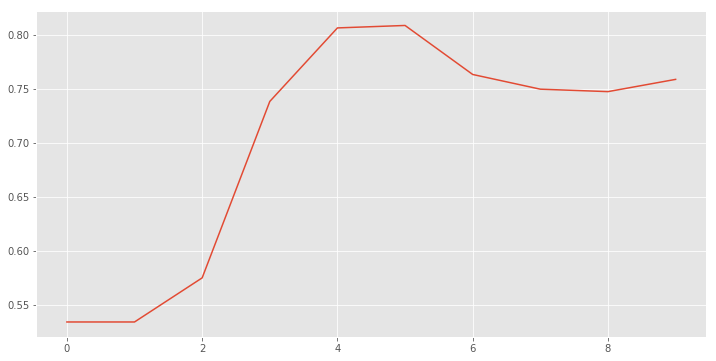

In [66]:
plt.plot(acc)